<a href="https://colab.research.google.com/github/IslombekTurakulov/NotebookWorks/blob/main/TurakulovIslombek_Alg_15_2020_hyp_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [8]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius

    def asymptote(self, x='x', y='y',_slope=None, equation=False):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)

      dx = x - self.center.x
      dy = y - self.center.y

      if _slope is not None:
        a = self.hradius
        b = self.vradius
        k1 = (b+a*_slope)/(a-b*_slope)
        k2 = (-b+a*_slope)/(a+b*_slope)
        res1 = dy - k1*dx
        res2 = dy - k2*dx
      else:
        res1 = dx/self.hradius + dy/self.vradius
        res2 = dx/self.hradius - dy/self.vradius
      res1 = res1.simplify()
      res2 = res2.simplify()

      if not equation:
        return res1, res2
      else:
        free1 = res1.subs({x:0, y:0})
        free2 = res2.subs({x:0, y:0})

        return Eq(y, *sympy.solve(res1, y)), Eq(y, *sympy.solve(res2, y))

    def directrix(self, x='x',y='y',_slope=None, equation=False):
      x = _symbol(x, real=True)
      dx = x - self.center.x
      
      if _slope is not None:
        y = _symbol(y, real=True)
        dy = y - self.center.y
        res1 = dy + dx/_slope + self.hradius/self.eccentricity*sympy.sqrt(1 + 1/_slope) 
        res2 = dy + dx/_slope - self.hradius/self.eccentricity*sympy.sqrt(1 + 1/_slope)
      else:
        res1 = dx -self.hradius/self.eccentricity
        res2 = dx + self.hradius/self.eccentricity

      res1 = res1.simplify()
      res2 = res2.simplify()
      if not equation:
        return res1, res2
      else:
        free1 = res1.subs({x:0, y:0})
        free2 = res2.subs({x:0, y:0})
        return Eq(res1 - free1, -free1), Eq(res2-free2, -free2)

    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [9]:
Hyp1 = Hyperbola(Point(1, 2), hradius=12, vradius=5)

props = {'eccentricity': Hyp1.eccentricity, 'periapsis': Hyp1.periapsis,
         'focus_distance': Hyp1.focus_distance, 'foci': Hyp1.foci,
         'equation':Hyp1.equation(equation=True).simplify()}
for key in props.keys():
    display(key, props[key])

'eccentricity'

13/12

'periapsis'

1

'focus_distance'

13

'foci'

(Point2D(-12, 2), Point2D(14, 2))

'equation'

Eq((x - 1)**2/144 - (y - 2)**2/25, 1)

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [10]:
display("asymptote", *Hyp1.asymptote(equation=True))
display("directrix", *Hyp1.directrix(equation=True))

'asymptote'

Eq(y, 29/12 - 5*x/12)

Eq(y, 5*x/12 + 19/12)

'directrix'

Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

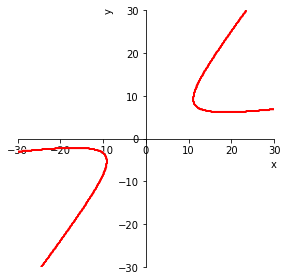

(3*x + sqrt(3)*(y - 2) - 3)**2/1728 - (-3*y + sqrt(3)*(x - 1) + 6)**2/300 - 1

In [11]:
eqHyp = Hyp1.equation(x='x', y='y', _slope=sympy.tan(sympy.pi/6))
dict_free = {str(a): a for a in eqHyp.free_symbols}
plot_implicit(eqHyp, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30), 
              line_color='r', aspect_ratio=(1, 1), adaptive=False)
display(eqHyp.simplify())

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

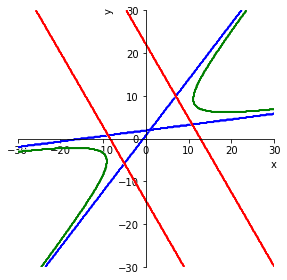

In [12]:
asymptote = Hyp1.asymptote( _slope=sympy.tan(sympy.pi/6))
dirextrix = Hyp1.directrix( _slope=sympy.tan(sympy.pi/6))
p = plot_implicit(eqHyp, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30), 
              line_color='g', aspect_ratio=(1, 1), adaptive=False, show = False)
for i, item in enumerate(asymptote + dirextrix):
  if i<2:
    color = 'b'
  else:
    color = 'r'
    
  p.extend(
      plot_implicit(item, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30), 
              line_color=color, aspect_ratio=(1, 1), adaptive=False, show = False)
  )
p.show()

###  Индивидуальное задание 139
Определить гиперболу с центром в точке $O=Point2D(4,-2)$, полуосями $a=8$ и $b=4$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha=\cfrac{\pi}{3}$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.

In [24]:
def colorFunc(col):
  return 'r' if i>2 else 'b'

Hyp1 = Hyperbola(Point(4, -2), hradius=8, vradius=4)

props = {'eccentricity': Hyp1.eccentricity, 'periapsis': Hyp1.periapsis,
         'focus_distance': Hyp1.focus_distance, 'foci': Hyp1.foci,
         'equation':Hyp1.equation(equation=True).simplify()}
for key in props.keys():
    display(key, props[key])

'eccentricity'

sqrt(5)/2

'periapsis'

-8 + 4*sqrt(5)

'focus_distance'

4*sqrt(5)

'foci'

(Point2D(4 - 4*sqrt(5), -2), Point2D(4 + 4*sqrt(5), -2))

'equation'

Eq((x - 4)**2/64 - (y + 2)**2/16, 1)

-5*sqrt(3)*x - 8*x + y + 34 + 20*sqrt(3)

-5*sqrt(3)*x + 8*x + y - 30 + 20*sqrt(3)

y + sqrt(3)*(x/3 - 4/3) + 2 + 16*sqrt(15*sqrt(3) + 45)/15

y + sqrt(3)*(x/3 - 4/3) - 16*sqrt(15*sqrt(3) + 45)/15 + 2

(x + sqrt(3)*(y + 2) - 4)**2/256 - (y - sqrt(3)*(x - 4) + 2)**2/64 - 1

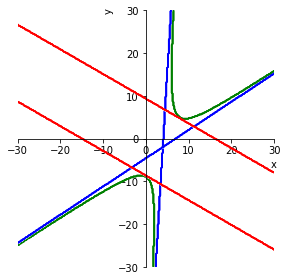

In [25]:
eqHyp = Hyp1.equation(x='x', y='y', _slope=sympy.tan(sympy.pi/3))
asymptote = Hyp1.asymptote( _slope=sympy.tan(sympy.pi/3))
dirextrix = Hyp1.directrix( _slope=sympy.tan(sympy.pi/3))
p = plot_implicit(eqHyp, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30), 
              line_color='g', aspect_ratio=(1, 1), adaptive=False, show = False)
for i, item in enumerate(asymptote + dirextrix):
  color = colorFunc(i)
  display(item)
  p.extend(plot_implicit(item, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30), line_color=color, aspect_ratio=(1, 1), adaptive=False, show = False))
display(eqHyp)
p.show()